# Laboratory #09 : Image Segmentation using UNet

At the end of this laboratory, you would get familiarized with

*   Segmentation using UNet
*   Understand the evaluation metrics
*   Importance of data annotations

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   You will have to mount your drive if you need to access images.
*   **Once you have the code completed, use GPU to train model faster.**

---

In [1]:
from skimage import color, data, io, segmentation
import numpy as np
import glob
import datetime
import shutil
from pathlib import Path
import matplotlib.pyplot as plt
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import jaccard_score
import tensorflow as tf

In [2]:
def plotImages(images, grid=(2, 2), figsize=(15, 9), **kwargs):
    f, ax = plt.subplots(grid[0], grid[1], figsize=figsize)
    for imageIdx, (title, image) in enumerate(images.items()):
        if grid[0] == 1:
            ax[imageIdx].set_title(title)
            ax[imageIdx].imshow(image, **kwargs)
            ax[imageIdx].axis('off')
        else:
            ax[imageIdx//grid[1]][imageIdx%grid[1]].set_title(title)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].imshow(image, **kwargs)
            ax[imageIdx//grid[1]][imageIdx%grid[1]].axis('off')
    return f, ax

# Loading dataset

*   We will use the [Tray Food Segmentation dataset](https://www.kaggle.com/thezaza102/tray-food-segmentation) for this laboratory.
*   You have two options to get the dataset into your notebook
    *   The dataset is already available in campus virtual. Upload the dataset to your drive before starting the exercise.
    *   You can use the kaggle APIs to get the dataset into the notebook directly (Advanced option).

# Constants

*   Change the path of the directories according to your drive location.

In [3]:
train_img = './TrayDataset/XTrain'
train_mask = './TrayDataset/yTrain'
test_img = './TrayDataset/XTest'
test_mask = './TrayDataset/yTest'

*   Define the constants needed for training the model

In [4]:
img_size = (160, 160)
num_classes = 43  # fixed for this dataset
batch_size = 32
epochs = 15  # find the best epoch that works for this problem

# Paths to Input Images and Segmentation Masks

*   We prepare the list of images and masks for both the train and test set

In [5]:
import os

train_img_paths = sorted(
    [
        os.path.join(train_img, fname)
        for fname in os.listdir(train_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

train_mask_paths = sorted(
    [
        os.path.join(train_mask, fname)
        for fname in os.listdir(train_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

test_img_paths = sorted(
    [
        os.path.join(test_img, fname)
        for fname in os.listdir(test_img)
        if fname.endswith(".jpg") or fname.endswith(".JPG")
    ]
)

test_mask_paths = sorted(
    [
        os.path.join(test_mask, fname)
        for fname in os.listdir(test_mask)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of train samples:", len(train_img_paths))
print("Number of train masks:", len(train_mask_paths))

print("Number of test samples:", len(test_img_paths))
print("Number of test masks:", len(test_mask_paths))

Number of train samples: 1241
Number of train masks: 1241
Number of test samples: 8
Number of test masks: 8


# Visualizing input image and corresponding segmentation mask

*   Visualize one train image and the corresponding segmentation mask in a matplotlib subplot
*   Also, show the mask overlayed on the original image.

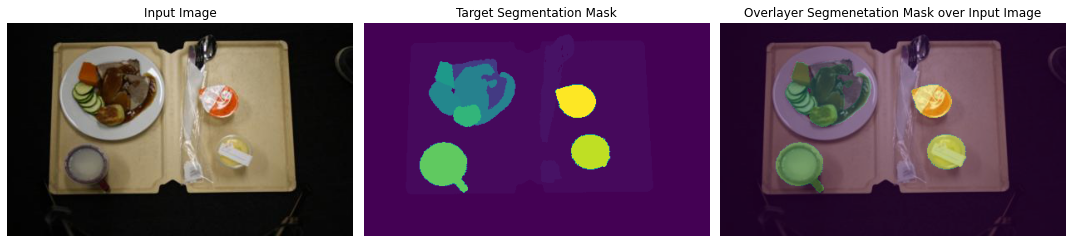

In [6]:
# solution
image_path, mask_path = train_img_paths[0], train_mask_paths[0]
image, mask = io.imread(image_path), io.imread(mask_path, as_gray=True)
images = {
    'Input Image': image,
    'Target Segmentation Mask': mask,
    'Overlayer Segmenetation Mask over Input Image': image
}
_, ax = plotImages(images, grid=(1, 3), figsize=(15, 9))
ax[2].imshow(mask, alpha=0.4)
plt.tight_layout()
plt.show()

# Image Generator

*   Create an image generator class (similar to the tutorial) to iterate over the images and return a tuple corresponding to the batch number.
*   The generator should inherit from the Sequence class.
*   It should have \_\_init\_\_(), \_\_len\_\_() and \_\_getitem\_\_() methods.
*   The batch size, image size, image paths and mask paths should be initialized using the \_\_init\_\_ method.

In [7]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class TrayDataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
        return x, y

# U-Net Xception-style model

*   We will use the same model architecture that we followed in the tutorial for this exercise

In [8]:
from tensorflow.keras import layers, Input, Model


def get_model(img_size, num_classes):
    inputs = Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = Model(inputs, outputs)
    return model
    

In [9]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

In [10]:
# Build model

model = get_model(img_size, num_classes)

*   Print the summary of the model

In [11]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Instantiate Image Generators for each split

*   For this experiment, we will use the test split as the validation generator
*   Instantiate image generator for each data split.

In [12]:
train_gen = TrayDataset(batch_size, img_size, train_img_paths, train_mask_paths)
val_gen = TrayDataset(8, img_size, test_img_paths, test_mask_paths)

# Train Model

*   Configure the model for training
    *   Use 'Sparse Categorical Crossentropy' loss for training
    *   Use 'rmsprop' optimizer

In [13]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

*   Instantiate a ModelCheckpoint callback to save only the best model

In [14]:
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)]

*   Train the model using fit method

In [15]:
#model.fit(train_gen, epochs=epochs, validation_data=val_gen, monitor='val_accuracy', callbacks=callbacks)
model.load_weights('models/segmentation_12-15-2020_0.189.h5')  # model can be loaded from previous executions

# Visualize predictions



In [16]:
batch_size = 1  # we define batch_size as 1 for inferencing

val_gen = TrayDataset(batch_size, img_size, test_img_paths, test_mask_paths)

*   Generate predictions for all images in the validation set

In [17]:
val_preds = model.predict(val_gen)

*   The mask is determined by the maximum value along the final axis. For all the predictions get the value of the predicted mask.

In [18]:
val_masks = np.argmax(val_preds, axis=-1)
print("val_masks shape: ", val_masks.shape)

val_masks shape:  (8, 160, 160)


*   Read the test mask images to create the ground truth

In [19]:
#solution

ground_truth = np.array([target_batch.squeeze(0) for _, target_batch in val_gen]).squeeze(-1)
print("ground truth shape: ", ground_truth.shape)

ground truth shape:  (8, 160, 160)


*   For each validation image, find the jaccard similarity score

In [20]:
from sklearn.metrics import jaccard_score

for pred, gt in zip(val_masks, ground_truth):
    js = jaccard_score(pred.flatten(), gt.flatten(), average='micro')
    print(js)

0.919112410510139
0.9338268620637559
0.8221289013843909
0.956064947468959
0.8499783205665559
0.9100914008580488
0.840733417220924
0.959508591985916


*   What do you understand from the 'average' parameter?
*   What are the different values of 'average' parameter? 
*   Which parameter is used for what type of problem?

**Solution**

- If an type of averaging is specified, it is computed over all the results (for all classes) of the jaccard similarity coefficient between the ground truth and the predicted masks. Otherwise, the scores for each class are returned.  


- The different values of the 'average' parameter are:  

    - 'binary': Only report results for the class specified by pos_label. This is applicable only if targets (y_{true,pred}) are binary.  
    
    - 'micro': Calculate metrics globally by counting the total true positives, false negatives and false positives.  

    - 'macro': Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.  

    - 'weighted': Calculate metrics for each label, and find their average, weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance.  

    - 'samples': Calculate metrics for each instance, and find their average (only meaningful for multilabel classification).  
    
  
- The different values of the 'average' parameter are used for:

    - 'binary': Used for binary classification or regression tasks.

    - 'micro': Makes no discrimination or weighting. 

    - 'macro': Macro can be used to regularize the absence of some classes in the different instances of the test data.

    - 'weighted': Weighted can be used to compute the weighted average of a multi-class classification, compensating the class imbalance.

    - 'samples': Samples can be used to perform the standard mean normalization by the length of the dataset.
    
    - 'None': Used to obtain scores for each class individually.

*   Randomly display one image, groundtruth mask, overlayed groundtruth mask, prediction mask, overlayed prediction mask using matplotlib 

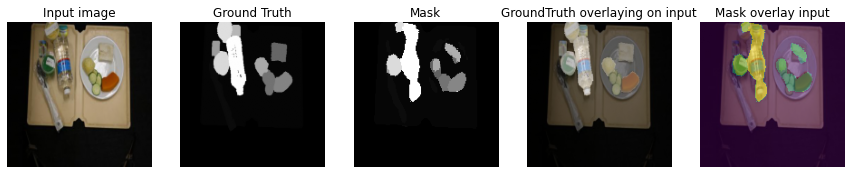

In [21]:
from matplotlib import pyplot as plt
from PIL.ImageOps import autocontrast
from skimage.io import imread
from skimage.transform import resize

i = 6 # validation image index to display results 

background = resize(imread(test_img_paths[i]), (160, 160))
mask = val_masks[i]
ground_truth = resize(np.array(autocontrast(load_img(test_mask_paths[i]))), (160, 160))

images = {'Input image': background,
          'Ground Truth': ground_truth,
          'Mask': mask,
          'GroundTruth overlaying on input': background,
          'Mask overlay input': background}

f, axs = plotImages(images, (1, 5), figsize=(15, 10), cmap='gray')
axs[3].imshow(ground_truth, alpha=0.5)
axs[4].imshow(mask, alpha=0.5)
plt.show()

*   What are other evaluation metrics to compare the performance of segmentation?

**Solution**

Aside from Jaccard Similarity metric (Area of overlap), there's other evalution metrics as:

- Any mathematical set comparison technique (Dice, Cosine, ...)
- Intra/Inter-region uniformity
- Region Shape
- Number of mis-segmented pixels
- Position of mis-segmented pixels
- Number of objects in the image
- Feature values of segmented objects

# Testing Model in the wild

*   Download 5 images from the internet similar to the dataset used.
*   Use the trained model to segment the images

In [22]:
import glob
customImagesPaths = sorted(glob.glob("custom/*.jpg"))
customImages = []
for path in customImagesPaths:
    image = load_img(path, target_size=img_size)
    customImages.append(np.array(image))
customImages = np.array(customImages)

In [23]:
predictions = np.argmax(model.predict(customImages), axis=-1)

(160, 160, 3) (160, 160)


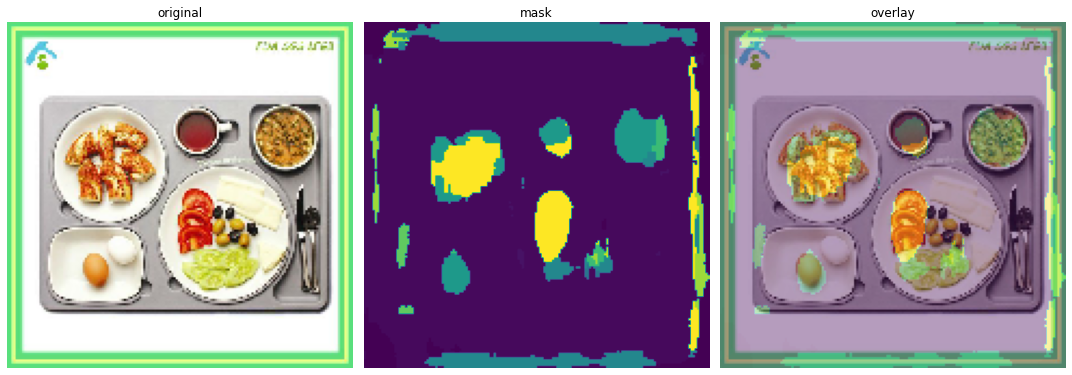

(160, 160, 3) (160, 160)


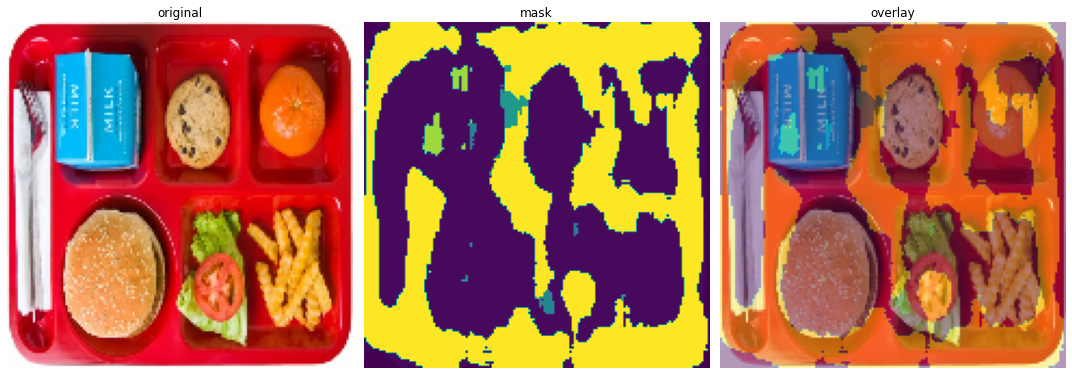

(160, 160, 3) (160, 160)


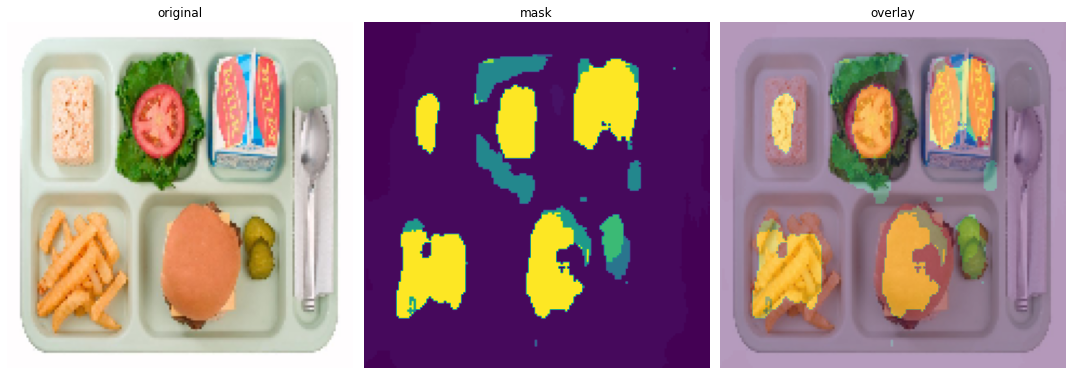

(160, 160, 3) (160, 160)


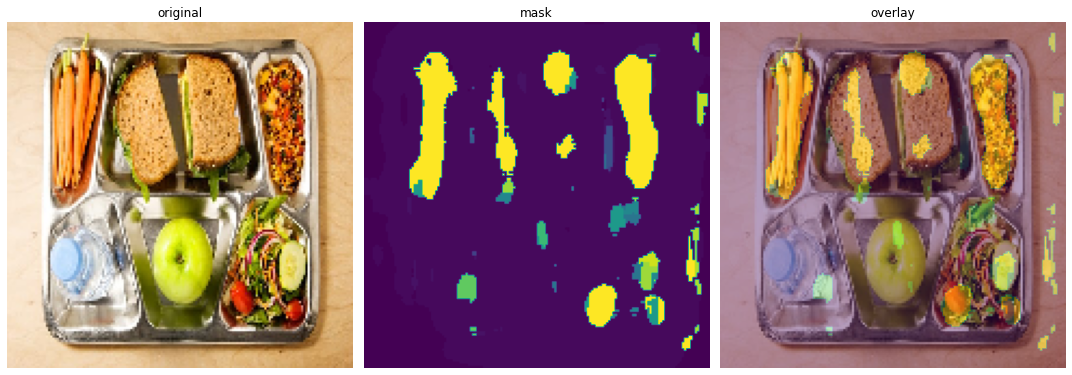

(160, 160, 3) (160, 160)


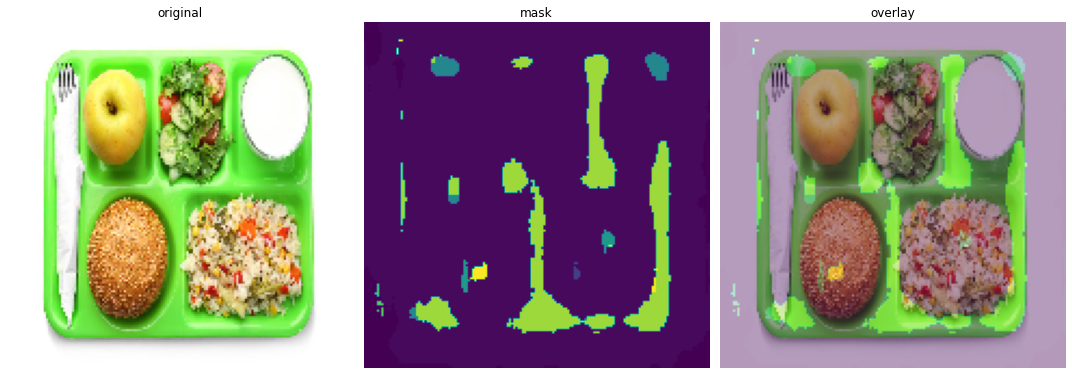

In [24]:
for image, predicted in zip(customImages, predictions):
    print(image.shape, predicted.shape)
    images = {
        'original': image,
        'mask': predicted,
        'overlay': image
    }
    _, ax = plotImages(images, grid=(1, 3), figsize=(15, 9))
    ax[2].imshow(predicted, alpha=0.4)
    plt.tight_layout()
    plt.show()

*   How accurate are the prediction masks?
*   What happens to the unlabelled classes?

**Solution**

- Given the variability of the domain labels or classes, the training dataset does not reflect all the possible objects that may appear in wild images taken the internet. Nonetheless, there may be some classes that are so distinct from all the others that it becomes easier to discriminate and classificate them, as for example the 'tray' objects.

- Their shape is misclassified or they are not even identified by the model.

*   What are the challenges when you use a trained model in the wild?
*   How can you develop a model to be used in real world?

**Solution**

- Generality of the models in distinct scenarios, Variations on the quality of the images, Variations on the object (rotations, scaling, illumination, ...), Perspective of the object (2D images of 3D objects).


- Making use of data augmentation techniques like noise addition, downsampling, rotations, scaling or/and increasing the size of the dataset. 

# Data Annotation using Labelme

*   Labelme is a GUI based image annotation tool which provides labeling for instance segmentation, semantic segmentation, bounding box detection and classification tasks.
*   Install labelme in your local machine (https://github.com/wkentaro/labelme)
*   Simple tutorial for single image example: https://github.com/wkentaro/labelme/tree/master/examples/tutorial
*   Semantic Segmentation example: https://github.com/wkentaro/labelme/tree/master/examples/semantic_segmentation

# Annotation for Tray food segmentation

*   Create labels.txt file that contains all the labels present in the tray food segmentation
*   *Hint: classes.csv file is present in the dataset folder*
*   *Check the labels file format in the semantic segmentation example* 

In [25]:
import csv

labels = open("labels.txt","w") 
with open('classes.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for idx, row in enumerate(spamreader):
        if idx:
            line = row[2].replace(" ", "_").replace("background", "_background_")
            labels.write(line + "\n")
        else:
            labels.write("__ignore__\n")
labels.close()

*   Use the labels.txt file in the labelme annotation studio and create annotations for the images you collected.
*   Save the annotations in a directory containing the label image and the label visualization (overlayed image).

In [26]:
# !labelme internet_images --labels labels.txt
# !python labelme2voc.py internet_images custom_voc --labels labels.txt

*   Convert the label.png of each image to grayscale format (similar to ytrain in the tray segmentation dataset).

In [27]:
internet_png = 'custom_voc/SegmentationClassPNG'

internet_png_paths = sorted(
    [
        os.path.join(internet_png, fname)
        for fname in os.listdir(internet_png)
        if fname.endswith(".png") or fname.endswith(".PNG")
    ]
)

y = np.zeros((len(internet_png_paths),) + img_size, dtype="uint8")
for j, path in enumerate(internet_png_paths):
    img = load_img(path, target_size=img_size, color_mode="grayscale")
    y[j] = img

print(y.shape)

(5, 160, 160)


*   For each image, show the annotation you created, annotation overlayed on the original image, predicted mask, predicted mask overlayed on the original image using matplotlib plot.

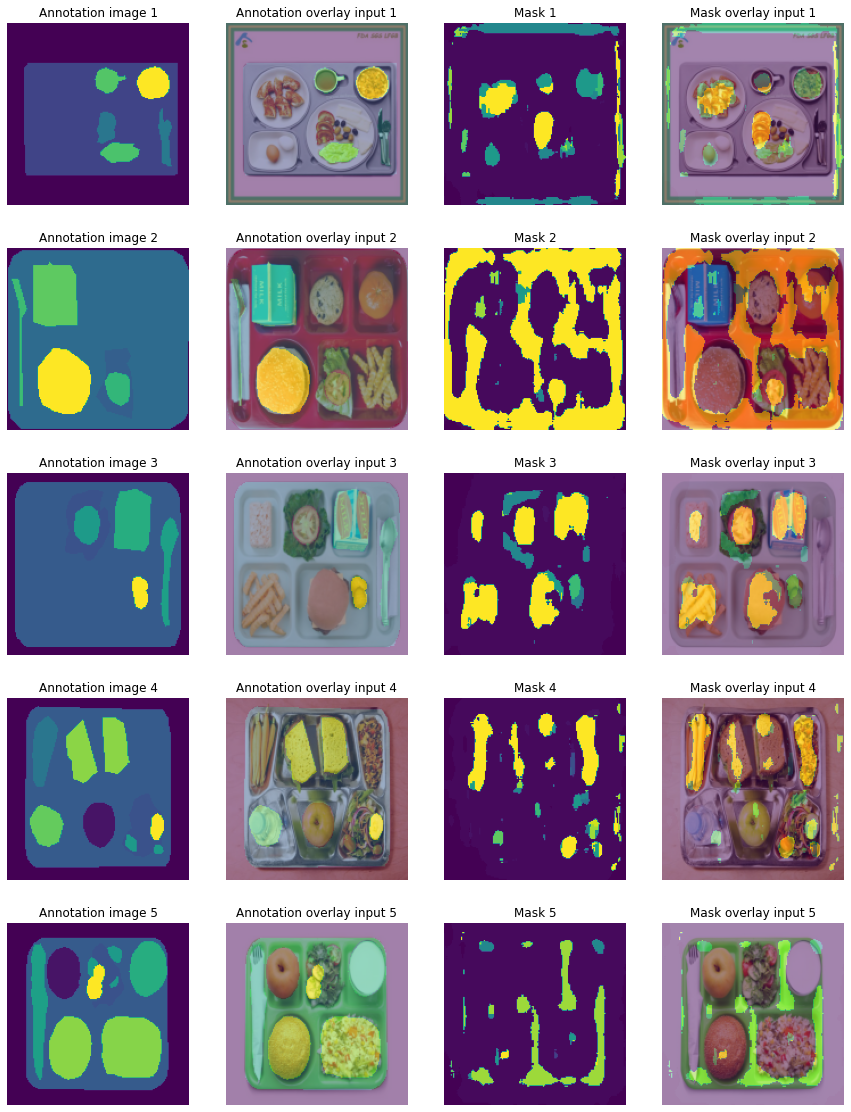

In [28]:
images = {}

for n in range(len(customImagesPaths)):
    background = resize(imread(customImagesPaths[n]), (160, 160))
    mask = predictions[n]
    images.update({f'Annotation image {n+1}': y[n],
                   f'Annotation overlay input {n+1}': background,
                   f'Mask {n+1}': mask,
                   f'Mask overlay input {n+1}': background})

f, axs = plotImages(images, (len(customImagesPaths), 4), figsize=(15, 20))
for n in range(len(customImagesPaths)):
    axs[n][1].imshow(y[n], alpha=0.5)
    axs[n][3].imshow(predictions[n], alpha=0.5)
    
plt.show()

*   Using the annotation you created, calculate the jaccard similarity score for each image.

In [29]:
jaccard_score(y.flatten(), predictions.flatten(), average='micro')

0.028447004848966933

*   What are the challenges in data annotation (as an annotator)?

**Solution**

- Establishing annotation guidelines
- Agreement between annotators
- Subjectivity or ambiguity in the annotation

*   What are the challenges in data annotation (as a computer vision engineer who builds models using annotated data)?

**Solution**

- Inaccuracies in the annotation data
- Uncertainty of the annotated object
- Similarity between distinct annotations
- General labels like _ignore_ or _background_
- Metadata (device used to capture the image, Resolution, Channels)

*   Are annotations always accurate? What types of errors occur with annotation in general?

**Solution**

Annotations are not always accurate as they are performed by humans (that are not perfect beings) and can produce inaccuracies, conflicts in data, add subjectivity, add bias and such.


---

## **End of P9: Image Segmentation using UNet**
Deadline for P9 submission in CampusVirtual is: **Thursday, the 17th of December, 2020**